# Machine learning for Chemistry - tutorial

## Project example 1  - Recurrent Neural networks

In this computer tutorial, we will build a recurrent neural network (RNN) to generate molecular structures. Several topics that we have learned throughout this course will come together in this assignment, including:
* SMILES codes to represent molecules,
* the RDKit library to draw molecular structures,
* the cross-entropy, which we will use for the loss function,
* PyTorch to design the neural network.

The main new concepts that we will learn in this tutorial are: 
1. building, training, and applying a recurrent neural network, 
1. using a neural network for generative modeling.


RNNs are powerful neural network architectures that can deal with sequential data and with time series. In contrast to a vanilla feed-forward neural network in which an input data point, $x_i$, transfers from the first hidden layer to the last hidden layer to result in an output $y_i$, in a recurrent neural network, an input $x_i$ is not only passed from the first hidden layer forward to the next layer, but also backward to work as input to the same hidden unit again. As a result, $x_i$ not only determines $y_i$, but also affects (together with $x_{i+1}$) the next output $y_{i+1}$, and also later output values. The network is said to have _memory_.

A common application for RNNs is in natural language processing, text can be seen as a sequences of sentences, a sentence is a sequence of words, and a word is a sequences of letters. For a given language, there is a relation between the letters in a word, and between the words in a sentence. In other words, given the first three letters of a word, for example "mac", the probability for a possible fourth letters is not a flat distribution over the English alphabet.


In this tutorial, we will use an RNN to learn the pattern in molecules and use that to construct new molecules. This is done using the SMILES representations of the molecules. A SMILES code is a sequence of letters and special tokens, which can be seen as words of a special language with a simple grammar.

We train the network to predict the next character in SMILES strings based on the previous character and the current memory state. The loss function represents a penalty for the incorrect prediction for the next character. When the network is trained enough, we can use it to sample new compounds. For sampling, we just put a <BOS> (begin of sequence) symbol as the initial token, and the network generates the next token. At the next step, we use this token as input and repeat the process to generate the full sequence of tokens. 

Tasks to fulfill:
* build a RNN with pytorch
* learn how to save and load the state of a (partially) trained neural network
* generate new SMILES codes
* visualize the generated molecules


In [1]:
# # first we load some useful libraries
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
import functools
from tqdm import tqdm
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw

__special__ = {0: "<PAD>", 1: "<BOS>", 2: "<EOS>"}
RDLogger.DisableLog('rdApp.*')

The class “SmilesProvider” inherits the PyTorch DataLoader class. At initialization, it "tokenizes" all molecules from a dataset and builds a dictionary with indexes for each SMILES token. Here a token is the smallest unit  used to make Smiles "words" and is made from 1 or 2 characters, such as "c", "C", "Si", etc.

In the following cell the “SmilesProvider” class is defined. We will just make of the class as is, e.g. to read the training set. 

$\color{DarkBlue}{\textbf{Task:}}$
* try to understand which <code>file</code> this class reads. This file is provided in the Canvas Module. Download and add this file to the same folder as this jupyter file. Open the file in jupyter lab or in a text editor, to see what is in this file.
* execute the cell


In [2]:
class SmilesProvider(torch.utils.data.DataLoader):
    def __init__(self, file, total=130):
        self.total = total
        self.smiles = open(file, 'r').read().split("\n")[:-1]
        tokens = functools.reduce(lambda acc,s: acc.union(set(s)), self.smiles ,set())
        self.vocsize = len(tokens) + len(__special__)
        self.index2token = dict(enumerate(tokens,start=3))
        self.index2token.update(__special__)
        self.token2index = {v:k for k,v in self.index2token.items()}
        self.ints = [torch.LongTensor([self.token2index[s] for s in line]) for line in tqdm(self.smiles,"Preparing of a dataset")]

    def decode(self,indexes):
        return "".join([self.index2token[index] for index in indexes if index not in __special__])

    def __getitem__(self,i):
        special_added = torch.cat((torch.LongTensor([self.token2index['<BOS>']])
                                   ,self.ints[i],torch.LongTensor([self.token2index['<EOS>']]),
                                   torch.LongTensor([self.token2index["<PAD>"]]*(self.total-len(self.ints[i])-2))),dim=0)
        return one_hot(special_added,self.vocsize).float(),special_added

    def __len__(self):
        return len(self.smiles)
    

Also the following class, we will just use and run as is...

In [3]:
class SimpleGRU(nn.Module):

    def __init__(self, vocsize, device, hidden_size=512, num_layers=3):
        super().__init__()
        self.device = device
        self.vocsize = vocsize
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(vocsize, hidden_size, bidirectional=False, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_size, vocsize)


    def forward(self, x):
        output = self.gru(x)[0]
        final = self.linear(output)
        return final

    def sample(self,batch_size=128,max_len=130):
        bos_token = [k for k,v in __special__.items() if v == "<BOS>"][0]
        x = torch.LongTensor([bos_token]*batch_size)
        h = torch.zeros((self.num_layers,batch_size,self.hidden_size)).to(self.device)
        accumulator = torch.zeros(batch_size,max_len)
        print(h.size())
        for i in range(max_len):
            x = one_hot(x, self.vocsize).float().unsqueeze(1).to(self.device)
            output,h = self.gru(x,h)
            next = F.softmax(self.linear(output).squeeze(1),dim=1)
            x = torch.multinomial(next,num_samples=1,replacement=True).squeeze(1)
            accumulator[:,i] = x
        return accumulator

## Generating Smiles strings

The <code>generate()</code> function generates Smiles strings.

$\color{DarkBlue}{\textbf{Task:}}$
* Use the RDKit function <code>Chem.MolFromSmiles()</code> to check if the produced Smiles is valid (it returns "None" on failure) and increase the variable <code>correct</code> otherwise.
* Set the PyTorch model in the <code>eval</code> modus in the correct place. (Note that this can be anywhere in the cell below)

In [4]:
def generate(file='genmodel.pt',batch_size=64):
    """
    This is the entrypoint for the generator of SMILES
    :param file: A file with pretrained model
    :param batch_size: The number of compounds to generate
    :return: None. It prints a list of generated compounds to stdout
    """
    box= torch.load(file)
    model,tokenizer = box['model'],box['tokenizer']
    model.eval()
    res = model.sample(batch_size)
    correct = 0
    list_smiles = []
    for i in range(res.size(0)):
        smiles = "".join([tokenizer[index] for index in res[i].tolist() if index not in __special__])
        # print(smiles)
# ======== start your code here =================================
        if Chem.MolFromSmiles(smiles) != None:
            correct += 1
            list_smiles.append(smiles)
# ======== end your code here ===================================
    # print ("% of correct molecules is {:4.2f}".format(correct/float(batch_size)*100))
    return list_smiles, correct/float(batch_size)*100

s, c = generate()
print(c, "%")


torch.Size([3, 64, 512])
76.5625 %


## Training the RNN

The recurrent neural network learns valid Smiles strings from the training data set of Smiles examples. However, running the training takes a lot of time, een on a fast GPU. 

We will therefore not actually perform the training here. Instead, we will load a trained state of the model and use that to do predictions.

Nevertheless, let's have a look at the training function <code>train</code> below, and fill in a number of blancs in the code.

$\color{DarkBlue}{\textbf{Task 1:}}$
In the relevant section below, add the following:
* set the <code>optimizer</code> variable to the "Adam" optimizer of Pytorch
* set the <code>loss_function</code> variable to a cross-entropy loss function from PyTorch nn module
* switch the PyTorch optimizer in the "train" mode.

$\color{DarkBlue}{\textbf{Task 2:}}$
In the relevant sections below, add in the correct spots:
* set the gradiants of the PyTorch optimizer to zero
* compute the backprop gradients for the loss function
* do a step with the optimizer

In [9]:
def train(file='250k.smi',batch_size=256,learning_rate=0.001,n_epochs=1,device='cuda'):
    """
    This is the entrypoint for training of the RNN
    :param file: A file with molecules in SMILES notation
    :param batch_size: A batch size for training
    :param learning_rate: A learning rate of the optimizer
    :param n_epochs: A number of epochs
    :param device: "cuda" for GPU training, "cpu" for training on CPU, if there are no CUDA on a computer it uses CPU only
    :return: None. It saves the model to "genmodel.pt" file
    """
    device = device if torch.cuda.is_available() else 'cpu'
    dataset = SmilesProvider(file)
    model = SimpleGRU(dataset.vocsize,device=device).to(device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# ======== TASK 1 start your code here =================================
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()
    model.train()
# ======== TASK 1 end your code here ===================================
    for epoch in range(1, n_epochs + 1):
        for iteration,(batch,target) in enumerate(tqdm(dataloader,'Training')):
            batch,target = batch.to(device),target.to(device)
            out = model(batch)
            out = out.transpose(2,1)
            loss = loss_function(out[:,:,:-1],target[:,1:])
            print(out.size(), target.size())
            print(loss)
# ======== TASK 2 start your code here =================================
            optimizer.zero_grad()
# ======== TASK 2 end your code here ===================================
            loss.backward()
# ======== TASK 2 start your code here =================================
            optimizer.step()
# ======== TASK 2 end your code here ===================================
            break

    model.device = 'cpu'
    torch.save({'tokenizer':dataset.index2token,'model':model.cpu()},"genmodelnew.pt")
train()



Training:   0%|          | 0/975 [00:00<?, ?it/s]

torch.Size([256, 37, 130]) torch.Size([256, 130])


Training:   0%|          | 0/975 [00:00<?, ?it/s]

tensor(3.6281, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


## Generating molecules

$\color{DarkBlue}{\textbf{Task:}}$
* call the <code>generate()</code> function to produce a list of molecules 

In [6]:
# ======== start your code here =================================
generate()
# ======== end your code here ===================================

torch.Size([3, 64, 512])


(['Cc1ccc(C)c(C=O)c1',
  'C#CCOc1cccc([C@H]2C[NH+]=C(N)C(C)(C)C2)c1',
  'COc1cccc(-c2ccc([O-])c(N)c2)c1',
  'Cc1noc(C)c1C[NH+]1CCN(c2ncc(C)s2)CC1',
  'Cc1cc([C@@](C)(O)[C@@H]2CCOC2)c(C)n1C1CC1',
  'COc1ccc(C)cc1NC(=O)N1C[C@H](O)N[C@@H](C)CC2=CC=C1CC2',
  'CS(=O)(=O)N1CCN(C(=O)CCc2c[nH]c(=O)[nH]2)C1',
  'CN1CC[C@@H]([NH3+])[C@H]1[C@@H]1CCOC1',
  'COc1cccc(NS(=O)(=O)c2cc3sccc3nc2S(=O)(=O)N2CCCCCC2)c1',
  'Cc1ccc(-n2ccnc2C#N)cc1N',
  'Cc1cc(NC(=O)[C@H]2CCN(C(=O)c3cc4ccccc4[nH]3)C2=O)c(C)n1C',
  'C[C@@H](c1ccccc1)c1ccc(/N=C/[N+]=N\\N)cc1',
  'CCS(=O)(=O)N1CCN(C(=O)c2c(C)[nH]c(=O)[nH]c2=O)C1',
  'COC(=O)C1=[N+](C)[C@@H](c2ccccc2)CC(=O)N1Cc1ccc(Cl)cc1Cl',
  'C[C@H]1CN([C@]2(O)CCCN(Cc3ccc(Br)cc3)C2)C[C@H](C)O1',
  'CCc1ccc([N-]S(=O)(=O)Cc2ccc(F)cc2)cc1C',
  'CC[C@@](O)(CCCO)C1([NH3+])CCCCC1',
  'CC[C@](C)([NH3+])C(=O)c1ccc2c(c1)oc(=O)n2C',
  'CC(C)SCc1cn[nH]n1',
  'O=C(Cn1nnc2ccccc2c1=O)N1CCC[C@@H]1c1cccnc1',
  'Cc1noc(C)c1CNC(=O)N[C@@H]1CCCC[C@@H]1c1ccccc1',
  'CCN(CC)C(=O)[C@@H](Br)C(F)(F)F

## Visualizing molecules

$\color{DarkBlue}{\textbf{Task:}}$
* Use RDKit to draw some of the produced chemical structures to assess how realistic they are.

torch.Size([3, 64, 512])


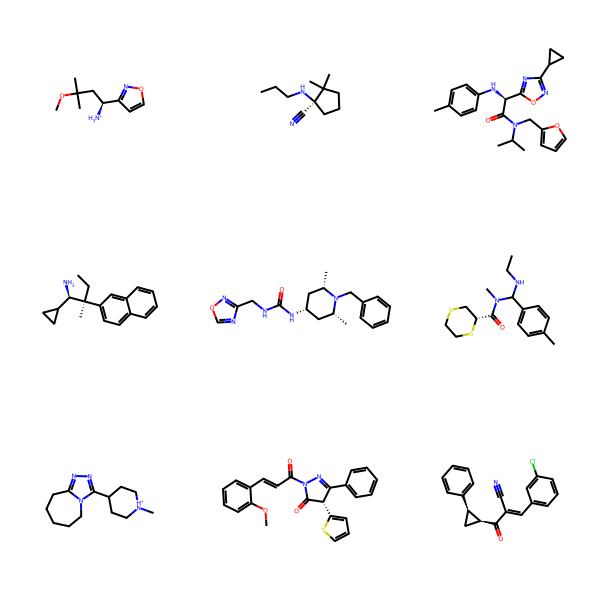

In [7]:
# ======== start your code here =================================
batch_size = 64
smiles, pc = generate(batch_size=batch_size)
n_print = 9
len_smiles = len(smiles)
indicies = []
mols = []
n = 0
while n < n_print:
    index = int(random.random() * len_smiles)
    if index not in indicies:
        indicies.append(index)
        mols.append(Chem.MolFromSmiles(smiles[index]))
        n += 1

Draw.MolsToGridImage(mols)


# ======== end your code here ===================================

$\color{DarkBlue}{\textbf{Question 1:}}$ How can the RNN model be further improved to generate useful molecules with certain desired properties?

$\color{Grey}{\textsf{<double-click and type your answer here>}}$

## Conclusions

This ends this part of the final ML4Chem Tutorial on Advanced Neural Networks.

In this tutorial, we have used a RNN to generate new molecules from Smiles strings. Apart from obtaining a deeper understanding of the possibilites of neural networks, the PyTorch library, saving and loading trainined networks, we hope that this tutorial has also inspired you to think of other possibilities and applications of machine learning for chemistry! 
